<a href="https://colab.research.google.com/github/wallet-maker/spectra/blob/main/notebooks/Spectra_Colaboratory_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dpeerlab/spectra

fatal: destination path 'spectra' already exists and is not an empty directory.


In [3]:
!ls

sample_data  spectra


In [4]:
%cd spectra

/content/spectra


In [5]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/spectra
  Preparing metadata (setup.py) ... done
  Created wheel for spectra: filename=spectra-0.1.0-py3-none-any.whl size=30021 sha256=c083862673cab1d19fdfd513854c63ca8acd177ffe6c872f005ff8c1e83812eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jp6tbqnc/wheels/7d/2a/d8/aee9bb70f56a7c3839c9e3f2489c721678a1d0af7d9be17623
Successfully built spectra
  Attempting uninstall: spectra
    Found existing installation: spectra 0.1.0
    Uninstalling spectra-0.1.0:
      Successfully uninstalled spectra-0.1.0


In [6]:
%pip install -U matplotlib==3.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from spectra import spectra as spc

In [8]:
#import packages
import numpy as np
import json 
import scanpy as sc
from collections import OrderedDict
import scipy 
import pandas as pd

#spectra imports 
from spectra import spectra as spc
from spectra import spectra_util as util
from spectra import K_est as kst



In [9]:
def get_factor_celltypes(adata, obs_key, cellscore_obsm_key = 'SPECTRA_cell_scores'):
    '''
    Assigns Spectra factors to cell types by analyzing the factor cell scores.
    Cell type specific factors will have zero cell scores except in their respective cell type
    
    adata: AnnData , object containing the Spectra output
    obs_key: str , column name in adata.obs containing the cell type annotations
    cellscore_obsm_key: str , key for adata.obsm containing the Spectra cell scores
    
    returns: dict , dictionary of {factor index : 'cell type'}
    '''
    
    #get cellscores
    import pandas as pd
    cell_scores_df = pd.DataFrame(adata.obsm[cellscore_obsm_key])
    cell_scores_df['celltype'] = list(adata.obs[obs_key])
    
    #find global and cell type specific fators
    global_factors_series = (cell_scores_df.groupby('celltype').mean() !=0).all()
    global_factors = [factor for factor in global_factors_series.index if global_factors_series[factor]]
    specific_cell_scores = (cell_scores_df.groupby('celltype').mean()).T[~global_factors_series].T
    specific_factors = {}
    
    for i in set(cell_scores_df['celltype']):
        specific_factors[i]=[factor for factor in specific_cell_scores.loc[i].index if specific_cell_scores.loc[i,factor]]
    
    #inverse dict factor:celltype
    factors_inv = {}
    for i,v in specific_factors.items():
        for factor in v:
            factors_inv[factor]=i
    
    #add global

    for factor in global_factors:
        factors_inv[factor]= 'global'
            
    return factors_inv

In [10]:
def check_gene_set_dictionary(adata, annotations, obs_key='cell_type_annotations',global_key='global', return_dict = True):
    '''
    Filters annotations dictionary contains only genes contained in the adata. 
    Checks that annotations dictionary cell type keys and adata cell types are identical.
    Checks that all gene sets in annotations dictionary contain >2 genes after filtering.
    
    adata: AnnData , data to use with Spectra
    annotations: dict , gene set annotations dictionary to use with Spectra
    obs_key: str , column name for cell type annotations in adata.obs
    global_key: str , key for global gene sests in gene set annotation dictionary
    return_dict: bool , return filtered gene set annotation dictionary
    
    returns: dict , filtered gene set annotation dictionary
    
    '''
    #test if keys match
    adata_labels  = list(set(adata.obs[obs_key]))+['global']#cell type labels in adata object
    annotation_labels = list(annotations.keys())
    matching_celltype_labels = list(set(adata_labels).intersection(annotation_labels))
    if set(annotation_labels)==set(adata_labels):
        print('Cell type labels in gene set annotation dictionary and AnnData object are identical')
        dict_keys_OK = True
    if len(annotation_labels)<len(adata_labels):
        print('The following labels are missing in the gene set annotation dictionary:',set(adata_labels)-set(annotation_labels))
        dict_keys_OK = False
    if len(adata_labels)<len(annotation_labels):
        print('The following labels are missing in the AnnData object:',set(annotation_labels)-set(adata_labels))
        dict_keys_OK = False
        
    #check that gene sets in dictionary have len >2
    Counter = 0
    annotations_new = {}
    for k,v in annotations.items():
        annotations_new[k] = {}
        for k2,v2 in v.items():
            annotations_new[k][k2]= [x for x in v2 if x in adata.var_names]
            length = len(v2)
            if length<3:
                print('gene set',k2,'for cell type',k,'is of length',length)
                Counter = Counter+1
            
    if Counter > 0:
        print(Counter,'gene sets are too small. Gene sets must contain at least 3 genes')
    elif Counter == 0 and dict_keys_OK:
        print('Your gene set annotation dictionary is correctly formatted.')
    if return_dict:
        return annotations_new

In [11]:
#load the default gene set dictionary from the Spectra paper:
import os
dict_path ='/content/spectra/data/Spectra_dict.json'
with open(dict_path, "rb") as file:
    annotations = json.load(file)

In [12]:
annotations["global"]["all_wnt-beta-catenin-signaling"]

['HDAC2',
 'LEF1',
 'CUL1',
 'TP53',
 'GNAI1',
 'DLL1',
 'SKP2',
 'AXIN1',
 'KAT2A',
 'CSNK1E',
 'MAML1',
 'FZD8',
 'NOTCH1',
 'MYC',
 'RBPJ',
 'JAG2',
 'PTCH1',
 'PPARD',
 'HDAC5',
 'AXIN2',
 'NUMB',
 'PSEN2',
 'NKD1',
 'WNT1',
 'TCF7',
 'FRAT1',
 'HDAC11',
 'ADAM17',
 'CCND2',
 'HEY1',
 'NCSTN',
 'JAG1',
 'DVL2',
 'NOTCH4',
 'NCOR2',
 'TPTEP2-CSNK1E',
 'FZD1',
 'CTNNB1',
 'DKK4',
 'HEY2',
 'WNT6',
 'DKK1',
 'WNT5B']

In [13]:
#define data paths
adata_path = '/content/spectra/data/sample_data.h5ad'#indicate where to find the gene expression AnnData object
obs_key = 'cell_type_annotations' #indicat the column name for the dataframe in adata.obs where to find the cell type lab

In [14]:
#load data
adata = sc.read(adata_path)
adata

AnnData object with n_obs × n_vars = 10000 × 6397
    obs: 'cell_type_annotations'
    var: 'n_cells_by_counts', 'highly_variable'
    uns: 'annotation_SPADE_1_colors', 'cell_type_annotations_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'neighbors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
#filter gene set annotation dict for genes contained in adata
annotations = check_gene_set_dictionary(adata, annotations, obs_key='cell_type_annotations',global_key='global')

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is correctly formatted.


In [16]:
#cell type labels in adata
list(set(adata.obs[obs_key]))

['DC',
 'B_GC',
 'MDC',
 'CD8_T',
 'B_naive',
 'plasma',
 'CD4_T',
 'Treg',
 'pDC',
 'B_memory',
 'gdT',
 'mast',
 'NK',
 'ILC3']

In [17]:
#cell type in gene set annotation dictionary
list(set(annotations.keys()))

['DC',
 'B_GC',
 'MDC',
 'CD8_T',
 'B_naive',
 'plasma',
 'CD4_T',
 'global',
 'Treg',
 'pDC',
 'B_memory',
 'gdT',
 'mast',
 'NK',
 'ILC3']

In [18]:
#filter gene set annotation dict for genes contained in adata
annotations = check_gene_set_dictionary(adata, annotations, obs_key='cell_type_annotations',global_key='global')

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is correctly formatted.


In [19]:
#fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata = adata, gene_set_dictionary = annotations['global'], # because we do not use the cell types
                                                                                    # we will supply a regular dict
                                                                                    # instead of the nested dict above
                        use_highly_variable = True, cell_type_key =None,# "cell_type_annotations" 
                        use_weights = True, lam = 0.1, 
                        delta=0.001,kappa = 0.00001, rho = 0.00001, 
                        use_cell_types = False, #set to False to not use the cell type annotations
                        n_top_vals = 25, 
                        num_epochs=2 #for demonstration purposes we will only run 2 epochs, we recommend 10,000 epochs
                       )



100%|██████████| 2/2 [00:14<00:00,  7.44s/it]


In [20]:
del model

In [21]:
#fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata = adata, gene_set_dictionary = annotations, 
                        use_highly_variable = True, cell_type_key = "cell_type_annotations", 
                        use_weights = True, lam = 0.1, 
                        delta=0.001,kappa = 0.00001, rho = 0.00001, 
                        use_cell_types = True, n_top_vals = 25, 
                        num_epochs=2 #for demonstration purposes we will only run 2 epochs, we recommend 10,000 epochs
                       )

100%|██████████| 2/2 [00:51<00:00, 25.65s/it]


In [22]:
#this is the model file which includes all outputs
dir(model)

['B_diag',
 'L',
 '_SPECTRA_Model__B_diag',
 '_SPECTRA_Model__eta_matrices',
 '_SPECTRA_Model__store_parameters',
 '_SPECTRA_Model__store_parameters_no_celltypes',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cell_scores',
 'delta',
 'eta_matrices',
 'factors',
 'gene_scalings',
 'initialize',
 'internal_model',
 'kappa',
 'lam',
 'load',
 'matching',
 'return_cell_scores',
 'return_eta',
 'return_eta_diag',
 'return_factors',
 'return_gene_scalings',
 'return_graph',
 'return_kappa',
 'return_rho',
 'rho',
 'save',
 'train',
 'use_cell_types']

In [23]:
#save the model file
model_save_path = 'example_model'
model.save(model_save_path)
print('Saved Spectra model to:',model_save_path)   

Saved Spectra model to: example_model


In [24]:
#the adata will contain the most important outputs from the Spectra model 
adata

AnnData object with n_obs × n_vars = 10000 × 6397
    obs: 'cell_type_annotations'
    var: 'n_cells_by_counts', 'highly_variable', 'spectra_vocab'
    uns: 'annotation_SPADE_1_colors', 'cell_type_annotations_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'neighbors', 'pca', 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_L'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap', 'SPECTRA_cell_scores'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [25]:
#find the markers under adata.uns['SPECTRA_markers']
adata.uns['SPECTRA_markers']

array([['BTD', 'HLCS', 'SLC5A6', ..., 'MPC2', 'CDKN3', 'IGFBP5'],
       ['GUK1', 'HPRT1', 'AK1', ..., 'SLC28A3', 'ALOX15', 'TRIM21'],
       ['AOX1', 'ZADH2', 'ALDH1A1', ..., 'CDC42EP1', 'DERL2', 'SATB1'],
       ...,
       ['RNF145', 'OTULINL', 'ZAP70', ..., 'XBP1', 'AC013264.1',
        'DCBLD2'],
       ['AC012617.1', 'PLD4', 'NAPSA', ..., 'CYB561A3', 'MSI2', 'SHC1'],
       ['POU2AF1', 'AMN1', 'SEC11C', ..., 'AL135790.1', 'SMPDL3A', 'PGR']],
      dtype=object)

In [26]:
#find the factors under adata.uns['SPECTRA_factors'] 
adata.uns['SPECTRA_factors']

array([[4.35636414e-14, 5.45213188e-12, 2.07700376e-13, ...,
        6.84046105e-14, 1.98389261e-12, 8.78715180e-13],
       [2.00040256e-13, 7.32717398e-13, 4.67110198e-13, ...,
        1.22820447e-13, 9.29412744e-14, 7.66761315e-12],
       [8.88579541e-14, 5.94574704e-13, 1.34615898e-11, ...,
        2.99572088e-14, 3.91166070e-13, 5.95030449e-12],
       ...,
       [1.43572862e-12, 5.53805154e-13, 9.75971001e-14, ...,
        7.28435317e-14, 8.50926582e-13, 1.86419725e-13],
       [4.78719723e-02, 3.67932754e-02, 3.45484814e-02, ...,
        1.90221406e-02, 4.08841597e-02, 4.54031190e-02],
       [1.08802315e-01, 4.46178172e-02, 4.21501074e-02, ...,
        4.88965329e-02, 1.09336956e-02, 6.64826045e-02]])

In [27]:
#it also includes a dictionary of the factor numbers per cell type
adata.uns['SPECTRA_L']

{'B_GC': 1,
 'B_memory': 5,
 'B_naive': 1,
 'CD4_T': 12,
 'CD8_T': 7,
 'DC': 3,
 'ILC3': 1,
 'MDC': 6,
 'NK': 1,
 'Treg': 2,
 'gdT': 1,
 'mast': 2,
 'pDC': 2,
 'plasma': 1,
 'global': 151}

In [28]:
#get factor celltype labels (the cell type will likely be provided directly by the model in future versions)
celltype_dict = get_factor_celltypes(adata, obs_key= obs_key, cellscore_obsm_key = 'SPECTRA_cell_scores')
celltype_dict

{177: 'DC',
 178: 'DC',
 179: 'DC',
 151: 'B_GC',
 181: 'MDC',
 182: 'MDC',
 183: 'MDC',
 184: 'MDC',
 185: 'MDC',
 186: 'MDC',
 170: 'CD8_T',
 171: 'CD8_T',
 172: 'CD8_T',
 173: 'CD8_T',
 174: 'CD8_T',
 175: 'CD8_T',
 176: 'CD8_T',
 157: 'B_naive',
 195: 'plasma',
 158: 'CD4_T',
 159: 'CD4_T',
 160: 'CD4_T',
 161: 'CD4_T',
 162: 'CD4_T',
 163: 'CD4_T',
 164: 'CD4_T',
 165: 'CD4_T',
 166: 'CD4_T',
 167: 'CD4_T',
 168: 'CD4_T',
 169: 'CD4_T',
 188: 'Treg',
 189: 'Treg',
 193: 'pDC',
 194: 'pDC',
 152: 'B_memory',
 153: 'B_memory',
 154: 'B_memory',
 155: 'B_memory',
 156: 'B_memory',
 190: 'gdT',
 191: 'mast',
 192: 'mast',
 187: 'NK',
 180: 'ILC3',
 0: 'global',
 1: 'global',
 2: 'global',
 3: 'global',
 4: 'global',
 5: 'global',
 6: 'global',
 7: 'global',
 8: 'global',
 9: 'global',
 10: 'global',
 11: 'global',
 12: 'global',
 13: 'global',
 14: 'global',
 15: 'global',
 16: 'global',
 17: 'global',
 18: 'global',
 19: 'global',
 20: 'global',
 21: 'global',
 22: 'global',
 23: 'gl

In [29]:
#so you can construct a dataframe for the factor gene weights

#include cell type specificity as a prefix into the index
index_labels = [celltype_dict[x]+'_'+str(x) for x in range(adata.uns['SPECTRA_factors'].shape[0])]
gene_weights = pd.DataFrame(adata.uns['SPECTRA_factors'], 
                            index= index_labels,
                            columns=adata.var[adata.var['spectra_vocab']].index)
gene_weights

,KCNC3,NDUFS3,HACD1,FAM214A,TBCD,AC124312.1,PLAGL2,CD40LG,AC022182.1,USP53,...,CCL3L1,BAG3,CDC42EP3,TRAM1,RANBP1,FDFT1,HACD4,FCGR3A,AZGP1,SLC35A1
global_0,4.356364e-14,5.452132e-12,2.077004e-13,2.257731e-13,2.268244e-12,2.602525e-14,7.605402e-14,1.524541e-14,1.014234e-13,1.145932e-13,...,1.697182e-13,5.993498e-14,4.584724e-13,3.809110e-12,2.109054e-12,1.102639e-13,3.633281e-12,6.840461e-14,1.983893e-12,8.787152e-13
global_1,2.000403e-13,7.327174e-13,4.671102e-13,9.056562e-14,2.139257e-11,4.736795e-14,1.015350e-13,9.396203e-15,9.265727e-14,4.218634e-13,...,1.564359e-13,5.277543e-14,1.128257e-13,1.528700e-13,1.039122e-12,3.119382e-13,1.858323e-12,1.228204e-13,9.294127e-14,7.667613e-12
global_2,8.885795e-14,5.945747e-13,1.346159e-11,9.579037e-14,7.497528e-13,1.112033e-13,1.005331e-13,6.290138e-14,7.850966e-14,2.052621e-13,...,4.348629e-13,1.186596e-13,1.074578e-13,4.067330e-13,4.947360e-13,2.272177e-13,1.525292e-11,2.995721e-14,3.911661e-13,5.950304e-12
global_3,1.869786e-14,1.349924e-13,2.711384e-13,7.944089e-14,3.092972e-13,4.103626e-14,1.353203e-13,7.316951e-14,2.430590e-14,8.322827e-14,...,1.551495e-13,1.680581e-13,1.060684e-13,1.556263e-13,7.705054e-12,7.648005e-14,2.314078e-13,2.024527e-13,6.755432e-13,4.355111e-13
global_4,7.540903e-14,2.959932e-13,1.366116e-12,8.042454e-14,1.886817e-12,4.047633e-14,1.222757e-13,1.067683e-13,4.727547e-13,1.320621e-13,...,2.409249e-13,5.231352e-14,7.501449e-14,9.352481e-13,2.189796e-12,3.744664e-02,4.298491e-14,1.143826e-13,4.794422e-13,1.008802e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mast_191,3.870500e-13,8.930766e-13,9.704270e-14,5.560821e-13,4.103713e-13,1.618993e-12,4.778962e-13,1.392698e-12,1.244996e-12,7.623092e-13,...,1.624466e-12,1.462573e-12,4.793904e-13,2.091417e-12,9.780933e-13,7.771222e-13,3.798712e-12,2.795134e-13,1.123249e-12,8.377997e-13
mast_192,3.794211e-02,6.428811e-02,3.533603e-02,5.443527e-02,2.259220e-02,4.109029e-02,1.363852e-02,2.866555e-02,3.486617e-02,9.091700e-02,...,4.502710e-02,6.241303e-02,5.997301e-02,6.742718e-02,3.820498e-02,3.819025e-02,4.835907e-02,7.921619e-02,5.145327e-02,1.127497e-01
pDC_193,1.435729e-12,5.538052e-13,9.759710e-14,1.022757e-12,2.499447e-13,4.432124e-13,9.841940e-13,6.206608e-13,5.233734e-13,6.392702e-13,...,5.704984e-13,1.996153e-12,2.296729e-13,5.209931e-13,2.021041e-13,2.030186e-13,8.124565e-13,7.284353e-14,8.509266e-13,1.864197e-13
pDC_194,4.787197e-02,3.679328e-02,3.454848e-02,4.441684e-02,1.701389e-02,3.485747e-02,2.383785e-02,1.232884e-02,1.430807e-01,2.678511e-02,...,1.654608e-02,9.884385e-02,3.861498e-02,2.045760e-02,3.651014e-02,1.459841e-02,3.496592e-02,1.902214e-02,4.088416e-02,4.540312e-02


In [30]:
#find the cell scores under adata.obsm['SPECTRA_cellscores']
adata.obsm['SPECTRA_cell_scores']

array([[9.58717014e-06, 1.15126414e-04, 2.70934846e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.31418109e-06, 3.80980870e-06, 1.62523909e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.16393229e-06, 1.59062226e-05, 1.41756293e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.91933558e-05, 3.21819752e-05, 4.61653272e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.40033313e-05, 4.59976381e-06, 2.30973233e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.47277026e-06, 1.26978452e-05, 1.41454974e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [31]:


#construct a dataframe for the cell scores

#include cell type specificity as a prefix into the column names
column_labels = [celltype_dict[x]+'_'+str(x) for x in range(adata.obsm['SPECTRA_cell_scores'].shape[1])]
cell_scores = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], 
                            index= adata.obs_names,
                            columns=column_labels)
cell_scores



,global_0,global_1,global_2,global_3,global_4,global_5,global_6,global_7,global_8,global_9,...,MDC_186,NK_187,Treg_188,Treg_189,gdT_190,mast_191,mast_192,pDC_193,pDC_194,plasma_195
0,0.000010,0.000115,0.000027,0.000038,0.000589,0.000006,0.000228,0.000137,3.155361e-07,1.140083e-06,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000006,0.000004,0.000016,0.000097,0.000280,0.000050,0.000217,0.000223,2.049155e-06,2.050467e-06,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000003,0.000016,0.000014,0.000066,0.000066,0.000093,0.000105,0.000567,9.497279e-07,6.448714e-07,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000016,0.000025,0.000003,0.000079,0.000724,0.000033,0.000310,0.000205,3.013527e-07,1.637163e-06,...,0.040405,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000051,0.000032,0.000001,0.000422,0.000584,0.000017,0.000086,0.000156,1.517451e-07,1.459311e-06,...,0.000000,0.0,0.000007,0.175324,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000010,0.000089,0.000012,0.000035,0.000250,0.000013,0.000302,0.000358,4.919654e-07,1.397941e-05,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.000013,0.000032,0.000015,0.000010,0.000128,0.000011,0.000040,0.000183,1.699713e-06,2.739945e-06,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.000019,0.000032,0.000005,0.000063,0.000069,0.000010,0.000266,0.000404,3.960000e-07,5.391940e-06,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000014,0.000005,0.000023,0.000039,0.000289,0.000022,0.000771,0.000212,2.986876e-07,5.028052e-06,...,0.061031,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


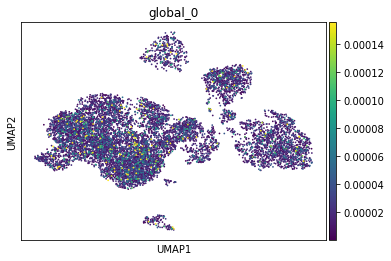

In [32]:
#visualize factor cell scores (this is poorly fitted bc we only ran 2 epochs)
factor_of_interest = 'global_0'
adata.obs[factor_of_interest] = cell_scores[factor_of_interest].astype(float)
sc.pl.umap(adata,color=factor_of_interest,vmax=cell_scores[factor_of_interest].quantile(0.99))

In [33]:
#save the adata
adata_save_path = 'adata_spectra.h5ad'#where to save the adata to
adata.write(adata_save_path)
print('Saved adata to:',adata_save_path)

Saved adata to: adata_spectra.h5ad


In [34]:
import pickle
with open('spectra_model.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [35]:
del model

In [36]:
with open('spectra_model.pickle', 'rb') as f:
    model = pickle.load(f)

In [37]:
model